<a href="https://colab.research.google.com/github/Bright-Momo/SimplifiedJournalsGame/blob/main/Update_for_3_authors_and_visulasation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.colors import ListedColormap
import seaborn as sns

In [3]:
# Parameters (same as in the original code)
alpha = 0.6    # Probability of a good paper
epsilon = 0.1  # Probability of misclassifying a good paper as bad
lam = 0.1      # Probability of misclassifying a bad paper as good
r = 1.0        # Reward for author when accepted
c = 0.5        # Cost for author when rejected

strategies = [0, 1, 2, 3]  # Always Submit, Only Submit Good, Only Submit Bad, No Submit

In [4]:
# Function to calculate acceptance probability
def acceptance_probability(is_good_paper, journal_strategy, epsilon, lam):
    if journal_strategy == 0:  # Always Accept
        return 1.0
    elif journal_strategy == 1:  # Only Accept Good
        return 1 - epsilon if is_good_paper else lam
    elif journal_strategy == 2:  # Only Accept Bad
        return epsilon if is_good_paper else 1 - lam
    else:  # Reject All
        return 0.0

In [6]:
# Calculate author and journal payoffs
def author_journal_payoff(author_strategy, journal_strategy, alpha, epsilon, lam, r, c):
    if author_strategy == 0:  # Always Submit
        good_prob, bad_prob = alpha, 1 - alpha
    elif author_strategy == 1:  # Only Submit Good
        good_prob, bad_prob = alpha, 0
    elif author_strategy == 2:  # Only Submit Bad
        good_prob, bad_prob = 0, 1 - alpha
    else:  # No Submit
        good_prob, bad_prob = 0, 0

    p_accept_good = acceptance_probability(True, journal_strategy, epsilon, lam)
    p_accept_bad = acceptance_probability(False, journal_strategy, epsilon, lam)

    accept_rate = good_prob * p_accept_good + bad_prob * p_accept_bad
    submit_rate = good_prob + bad_prob
    reject_rate = submit_rate - accept_rate

    author_payoff = accept_rate * r - reject_rate * c

    # Average quality of accepted papers (journal's payoff)
    if accept_rate > 0:
        journal_payoff = (good_prob * p_accept_good) / accept_rate
    else:
        journal_payoff = 0

    return author_payoff, journal_payoff

In [7]:
# Calculate author payoffs for a given strategy profile
def calculate_author_payoffs(author_strategies, journal_strategy, alpha, epsilon, lam, r, c):
    return [author_journal_payoff(author_strategy, journal_strategy, alpha, epsilon, lam, r, c)[0]
            for author_strategy in author_strategies]

# Calculate journal payoff for a given strategy profile
def calculate_journal_payoff(author_strategies, journal_strategy, alpha, epsilon, lam, r, c):
    journal_payoffs = [author_journal_payoff(author_strategy, journal_strategy, alpha, epsilon, lam, r, c)[1]
                      for author_strategy in author_strategies]
    # Average quality of all accepted papers
    return np.mean(journal_payoffs)


In [8]:
# Check if a strategy profile is a Nash equilibrium
def is_nash_equilibrium(strategy_profile, alpha, epsilon, lam, r, c):
    author_strategies = strategy_profile[:-1]  # First 3 elements
    journal_strategy = strategy_profile[-1]    # Last element

    # Calculate current payoffs
    author_payoffs = calculate_author_payoffs(author_strategies, journal_strategy, alpha, epsilon, lam, r, c)
    journal_payoff = calculate_journal_payoff(author_strategies, journal_strategy, alpha, epsilon, lam, r, c)

    # Check if any author can improve by deviating
    for i in range(len(author_strategies)):
        for alt_strategy in strategies:
            if alt_strategy == author_strategies[i]:
                continue

            # Create new strategy profile with one author deviating
            new_author_strategies = list(author_strategies)
            new_author_strategies[i] = alt_strategy

            # Calculate payoff with deviation
            new_payoff = author_journal_payoff(alt_strategy, journal_strategy, alpha, epsilon, lam, r, c)[0]

            # If author can improve by deviating, this is not a Nash equilibrium
            if new_payoff > author_payoffs[i]:
                return False

    # Check if journal can improve by deviating
    for alt_strategy in strategies:
        if alt_strategy == journal_strategy:
            continue

        # Calculate journal payoff with deviation
        new_journal_payoff = calculate_journal_payoff(author_strategies, alt_strategy, alpha, epsilon, lam, r, c)

        # If journal can improve by deviating, this is not a Nash equilibrium
        if new_journal_payoff > journal_payoff:
            return False

    # If no player can improve by deviating, this is a Nash equilibrium
    return True

In [9]:
# Find all Nash equilibria
def find_nash_equilibria(alpha, epsilon, lam, r, c):
    nash_equilibria = []

    # Generate all possible strategy profiles
    all_strategy_profiles = list(itertools.product(strategies, repeat=4))  # 3 authors + 1 journal

    print(f"Checking {len(all_strategy_profiles)} strategy profiles for Nash equilibria...")

    # Check each strategy profile
    for profile in tqdm(all_strategy_profiles):
        if is_nash_equilibrium(profile, alpha, epsilon, lam, r, c):
            nash_equilibria.append(profile)

    return nash_equilibria


In [10]:
# Display results in a more readable format
def display_equilibria(equilibria, alpha, epsilon, lam, r, c):
    print(f"\nFound {len(equilibria)} Nash equilibria:")

    for i, eq in enumerate(equilibria):
        author_strategies = eq[:-1]
        journal_strategy = eq[-1]

        author_payoffs = calculate_author_payoffs(author_strategies, journal_strategy, alpha, epsilon, lam, r, c)
        journal_payoff = calculate_journal_payoff(author_strategies, journal_strategy, alpha, epsilon, lam, r, c)

        print(f"\nEquilibrium #{i+1}:")
        print(f"  Author strategies: {author_strategies}")
        print(f"  Journal strategy: {journal_strategy}")
        print(f"  Author payoffs: {author_payoffs}")
        print(f"  Journal avg quality: {journal_payoff:.2f}")

        # Interpret strategies
        author_strat_names = []
        for s in author_strategies:
            if s == 0:
                author_strat_names.append("Always Submit")
            elif s == 1:
                author_strat_names.append("Only Submit Good")
            elif s == 2:
                author_strat_names.append("Only Submit Bad")
            else:
                author_strat_names.append("No Submit")

        if journal_strategy == 0:
            journal_strat_name = "Always Accept"
        elif journal_strategy == 1:
            journal_strat_name = "Only Accept Good"
        elif journal_strategy == 2:
            journal_strat_name = "Only Accept Bad"
        else:
            journal_strat_name = "Reject All"

        print(f"  Interpretation:")
        for i, strat in enumerate(author_strat_names):
            print(f"    Author {i+1}: {strat}")
        print(f"    Journal: {journal_strat_name}")

In [11]:
# Run the analysis
if __name__ == "__main__":
    # Get Nash equilibria
    equilibria = find_nash_equilibria(alpha, epsilon, lam, r, c)

    # Display results
    display_equilibria(equilibria, alpha, epsilon, lam, r, c)

Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 35569.68it/s]


Found 3 Nash equilibria:

Equilibrium #1:
  Author strategies: (1, 1, 1)
  Journal strategy: 1
  Author payoffs: [0.51, 0.51, 0.51]
  Journal avg quality: 1.00
  Interpretation:
    Author 1: Only Submit Good
    Author 2: Only Submit Good
    Author 3: Only Submit Good
    Journal: Only Accept Good

Equilibrium #2:
  Author strategies: (2, 2, 2)
  Journal strategy: 2
  Author payoffs: [0.3400000000000001, 0.3400000000000001, 0.3400000000000001]
  Journal avg quality: 0.00
  Interpretation:
    Author 1: Only Submit Bad
    Author 2: Only Submit Bad
    Author 3: Only Submit Bad
    Journal: Only Accept Bad

Equilibrium #3:
  Author strategies: (3, 3, 3)
  Journal strategy: 3
  Author payoffs: [0.0, 0.0, 0.0]
  Journal avg quality: 0.00
  Interpretation:
    Author 1: No Submit
    Author 2: No Submit
    Author 3: No Submit
    Journal: Reject All


In [12]:
# Analyze Nash equilibria across a grid of epsilon and lambda values
def analyze_equilibria_grid(alpha, r, c, grid_size=10):
    # Create grids for epsilon and lambda
    epsilon_values = np.linspace(0.01, 0.99, grid_size)
    lambda_values = np.linspace(0.01, 0.99, grid_size)

    # Initialize result arrays
    author_strategies = np.zeros((grid_size, grid_size, 3))  # Grid for each author
    journal_strategies = np.zeros((grid_size, grid_size))

    # Track if multiple equilibria exist
    multiple_equilibria = np.zeros((grid_size, grid_size), dtype=bool)

    # Calculate equilibria for each point in the grid
    for i, epsilon in enumerate(epsilon_values):
        for j, lam in enumerate(lambda_values):
            equilibria = find_nash_equilibria(alpha, epsilon, lam, r, c)

            if equilibria:
                # If multiple equilibria, mark it and use the first one
                if len(equilibria) > 1:
                    multiple_equilibria[i, j] = True

                # Record the strategies from the first equilibrium
                eq = equilibria[0]
                author_strategies[i, j, 0] = eq[0]
                author_strategies[i, j, 1] = eq[1]
                author_strategies[i, j, 2] = eq[2]
                journal_strategies[i, j] = eq[3]

                # Determine most common author strategy
                # (will be used for visualization)
                strategy_counts = [0, 0, 0, 0]
                for s in range(3):
                    strategy_counts[int(eq[s])] += 1
                most_common_author_strategy = np.argmax(strategy_counts)

                # Store it in the first author's position (just for visualization)
                author_strategies[i, j, 0] = most_common_author_strategy

    return epsilon_values, lambda_values, author_strategies, journal_strategies, multiple_equilibria

In [13]:

# Create visualizations of the parameter space
def plot_equilibria(alpha, r, c, grid_size=10):
    """
    Generate plots showing how Nash equilibria change with epsilon and lambda
    for a given cost value.
    """
    print(f"Analyzing for c = {c}...")

    # Run the equilibrium analysis
    epsilon_values, lambda_values, author_strategies, journal_strategies, multiple_equilibria = analyze_equilibria_grid(alpha, r, c, grid_size)

    # Get the most common author strategy at each grid point
    most_common_author_strategy = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            # Count occurrences of each strategy
            strategy_counts = [0, 0, 0, 0]
            for s in range(3):
                strategy_counts[int(author_strategies[i, j, s])] += 1
            most_common_author_strategy[i, j] = np.argmax(strategy_counts)

    # Create colormap for strategy visualization
    strategy_names = ["Always Submit/Accept", "Only Good", "Only Bad", "No Submit/Reject All"]
    colors = ["royalblue", "seagreen", "indianred", "goldenrod"]
    cmap = ListedColormap(colors)

    # Create the plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Nash Equilibrium Strategies (α={alpha}, r={r}, c={c})', fontsize=14)

    # Plot for authors
    author_plot = axes[0].imshow(most_common_author_strategy, origin='lower', extent=[0, 1, 0, 1],
                                 cmap=cmap, aspect='auto', vmin=0, vmax=3)
    axes[0].set_title('Most Common Author Strategy')
    axes[0].set_xlabel('λ (error rate for bad papers)')
    axes[0].set_ylabel('ε (error rate for good papers)')

    # Plot for journal
    journal_plot = axes[1].imshow(journal_strategies, origin='lower', extent=[0, 1, 0, 1],
                                  cmap=cmap, aspect='auto', vmin=0, vmax=3)
    axes[1].set_title('Journal Strategy')
    axes[1].set_xlabel('λ (error rate for bad papers)')
    axes[1].set_ylabel('ε (error rate for good papers)')

    # Indicate points with multiple equilibria
    if np.any(multiple_equilibria):
        for i in range(grid_size):
            for j in range(grid_size):
                if multiple_equilibria[i, j]:
                    x = lambda_values[j]
                    y = epsilon_values[i]
                    axes[0].plot(x, y, 'ko', markersize=3)
                    axes[1].plot(x, y, 'ko', markersize=3)

    # Add colorbars
    cbar_labels = [f"{i}: {name}" for i, name in enumerate(strategy_names)]

    cbar_authors = fig.colorbar(author_plot, ax=axes[0], ticks=[0.375, 1.125, 1.875, 2.625])
    cbar_authors.ax.set_yticklabels(cbar_labels)

    cbar_journal = fig.colorbar(journal_plot, ax=axes[1], ticks=[0.375, 1.125, 1.875, 2.625])
    cbar_journal.ax.set_yticklabels(cbar_labels)

    plt.tight_layout()
    plt.savefig(f'nash_equilibria_c_{c}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [15]:
# Analyze a specific scenario
def analyze_specific_scenario(alpha, epsilon, lam, r, c):
    """
    Analyze the Nash equilibria for a specific parameter combination.
    """
    equilibria = find_nash_equilibria(alpha, epsilon, lam, r, c)

    print(f"\nNash Equilibria for (α={alpha}, ε={epsilon}, λ={lam}, r={r}, c={c}):")
    if not equilibria:
        print("No pure strategy Nash equilibria found.")
        return

    strategy_names = ["Always Submit/Accept", "Only Submit/Accept Good",
                     "Only Submit/Accept Bad", "No Submit/Reject All"]

    for i, eq in enumerate(equilibria):
        author_strategies = eq[:-1]
        journal_strategy = eq[-1]

        # Calculate payoffs
        author_payoffs = calculate_author_payoffs(author_strategies, journal_strategy, alpha, epsilon, lam, r, c)
        journal_payoff = calculate_journal_payoff(author_strategies, journal_strategy, alpha, epsilon, lam, r, c)

        print(f"\nEquilibrium #{i+1}:")
        print(f"  Authors: {author_strategies} ({[strategy_names[s] for s in author_strategies]})")
        print(f"  Journal: {journal_strategy} ({strategy_names[journal_strategy]})")
        print(f"  Author Payoffs: {[round(p, 3) for p in author_payoffs]}")
        print(f"  Journal Quality: {round(journal_payoff, 3)}")

In [16]:
# Run the analysis for different cost values
def main():
    c_values = [0.01, 0.1, 0.5]

    # Analyze and visualize the parameter space for each cost
    for c in c_values:
        plot_equilibria(alpha=0.5, r=1.0, c=c, grid_size=10)

    # Analyze specific interesting scenarios
    print("\n\n=============== SPECIFIC SCENARIOS ===============")

    # Low cost, low errors
    analyze_specific_scenario(alpha=0.5, epsilon=0.1, lam=0.1, r=1.0, c=0.01)

    # Medium cost, medium errors
    analyze_specific_scenario(alpha=0.5, epsilon=0.5, lam=0.5, r=1.0, c=0.1)

    # High cost, high errors
    analyze_specific_scenario(alpha=0.5, epsilon=0.8, lam=0.8, r=1.0, c=0.5)

Analyzing for c = 0.01...
Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27687.32it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26881.18it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 30119.83it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 29533.29it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 29415.97it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22373.82it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 28501.63it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22775.31it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25921.39it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26457.92it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 29169.05it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24114.94it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27634.59it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27998.48it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 28765.82it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25195.15it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24124.15it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 28498.60it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24655.95it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27947.47it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 29993.63it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23572.30it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26244.51it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21394.82it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 28272.73it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24590.45it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26791.30it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25209.35it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27059.34it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19433.89it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25958.99it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27019.85it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23018.45it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23263.32it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18413.42it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22934.87it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19685.79it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21061.61it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25801.18it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25804.28it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 17145.30it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25028.95it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 31272.52it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22524.95it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 28782.79it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24884.51it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26450.10it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26167.13it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24174.66it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24657.65it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24207.36it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22509.37it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23278.96it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26579.74it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22885.99it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24710.42it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25305.00it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19901.80it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18251.29it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21376.50it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22046.73it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22724.69it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26886.56it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18268.06it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21533.84it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23608.58it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21803.64it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24915.69it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25325.29it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24763.99it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26904.08it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 32895.49it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25496.68it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26658.27it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19866.82it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25013.20it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25764.03it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23323.96it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20920.44it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26094.63it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25549.47it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25806.14it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23476.44it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25953.97it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 33936.21it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23131.02it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26053.47it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25625.07it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25150.89it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27063.44it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25572.59it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27262.02it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18001.61it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25049.97it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23488.76it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18513.11it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20880.98it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21252.96it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22578.47it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25730.08it/s]


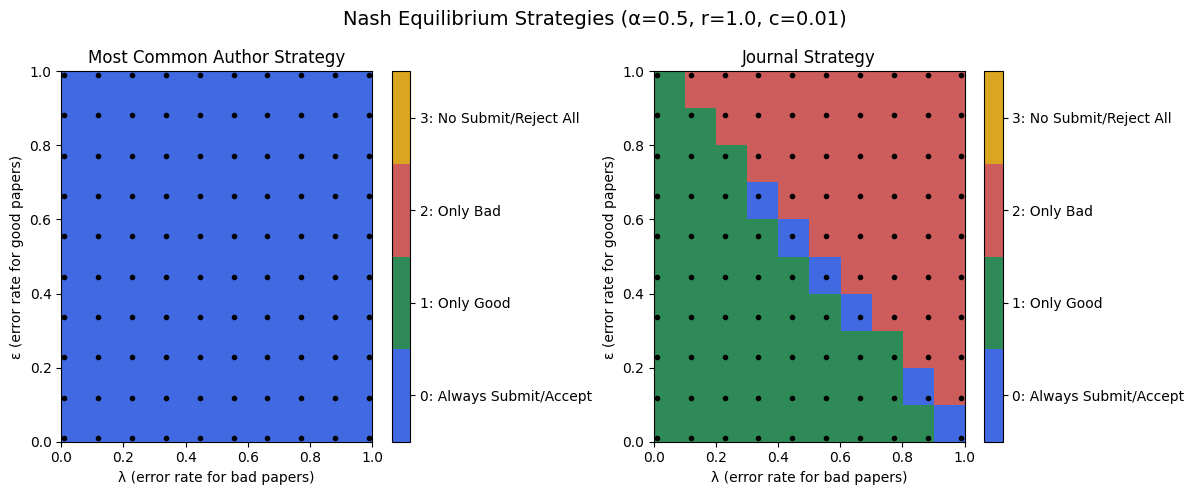

Analyzing for c = 0.1...
Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23482.60it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25454.98it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25809.24it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 15364.19it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 14171.44it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22603.19it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 13327.32it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18065.21it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19211.35it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18981.77it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 15475.80it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23221.56it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 14861.89it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20116.94it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21648.89it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 16146.98it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 16161.56it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 17798.40it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25919.51it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21026.96it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20959.65it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20666.37it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21156.64it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 12331.80it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 17181.79it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 17298.61it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19950.61it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20419.55it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26865.04it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19710.73it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 12802.76it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 11884.51it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 14890.33it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 15903.28it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24248.36it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18572.03it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25048.80it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19142.85it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21523.48it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21879.61it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19536.79it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19958.40it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24177.93it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 16747.65it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18250.98it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 15483.16it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 14758.93it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 15830.36it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 17315.62it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19406.14it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21407.62it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23511.91it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23483.11it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23262.82it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 17125.07it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 16701.54it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22449.13it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24911.65it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26761.25it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26310.11it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22517.86it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19915.46it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18418.47it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26385.10it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26624.56it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20783.98it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25378.57it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24531.46it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20486.17it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27525.49it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22534.88it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25703.59it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20007.86it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25969.67it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21003.52it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 16657.75it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20200.20it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21512.70it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27254.41it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26463.14it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23615.33it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19799.78it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20202.86it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20694.25it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22377.55it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26573.82it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26047.79it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26059.16it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25556.15it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21569.74it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18174.06it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19912.13it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23300.17it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22826.14it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22193.46it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 16198.62it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 17638.18it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26735.93it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26664.23it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20003.76it/s]


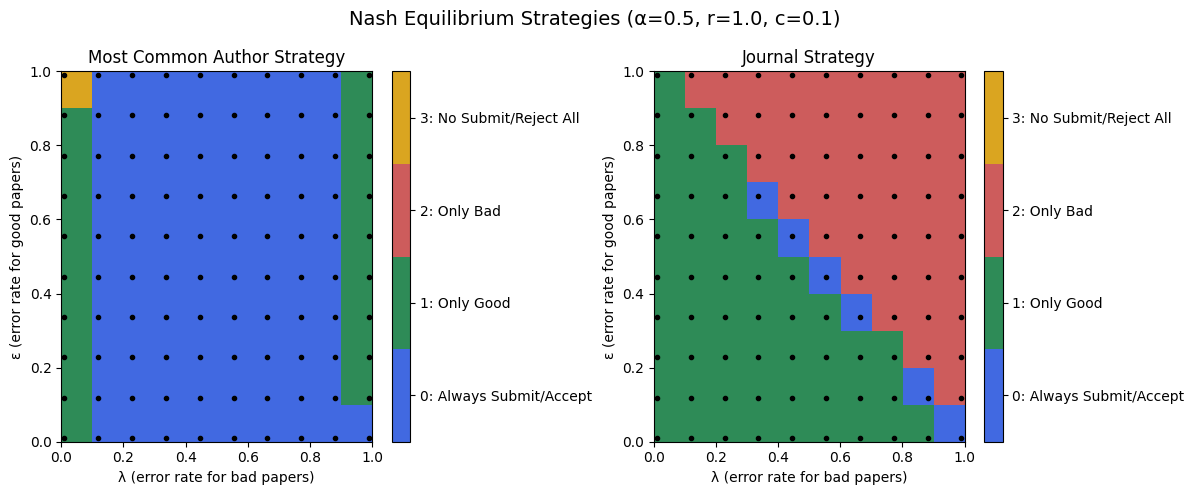

Analyzing for c = 0.5...
Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18124.06it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 17125.34it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 16943.47it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 15323.19it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 17417.58it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22982.98it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22922.14it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24429.87it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21658.06it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22440.68it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22083.91it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22748.29it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20314.86it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23574.37it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19243.72it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20207.43it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19341.82it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 20719.01it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25120.29it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 17388.53it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 16143.10it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 19382.67it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18320.74it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 16255.27it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23692.45it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25370.17it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23399.19it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25462.22it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23494.93it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21536.86it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22705.47it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25759.71it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25662.43it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22597.95it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21081.46it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25564.06it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25462.22it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23551.10it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18840.22it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 17735.49it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 14792.48it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27011.69it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26081.32it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25283.55it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23896.51it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27507.86it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25344.42it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25936.42it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24152.91it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23299.16it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 18165.45it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24886.82it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26694.06it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25279.98it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26295.29it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25832.84it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25955.86it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25165.04it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27974.41it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26328.17it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25180.97it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25790.02it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24882.78it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26617.30it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26527.21it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26467.05it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21387.58it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21306.94it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21324.29it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 21060.37it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22990.85it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25508.19it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25454.37it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23664.25it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24003.89it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22555.71it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25881.40it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26504.94it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24839.04it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25602.47it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25773.93it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25033.62it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 28203.67it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25418.82it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25645.27it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24810.91it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25646.50it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 17603.77it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23440.56it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22406.97it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24592.70it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26808.02it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24913.38it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 16563.19it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 24915.12it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 16660.07it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23601.83it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 25378.57it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 26014.34it/s]


Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 22406.97it/s]


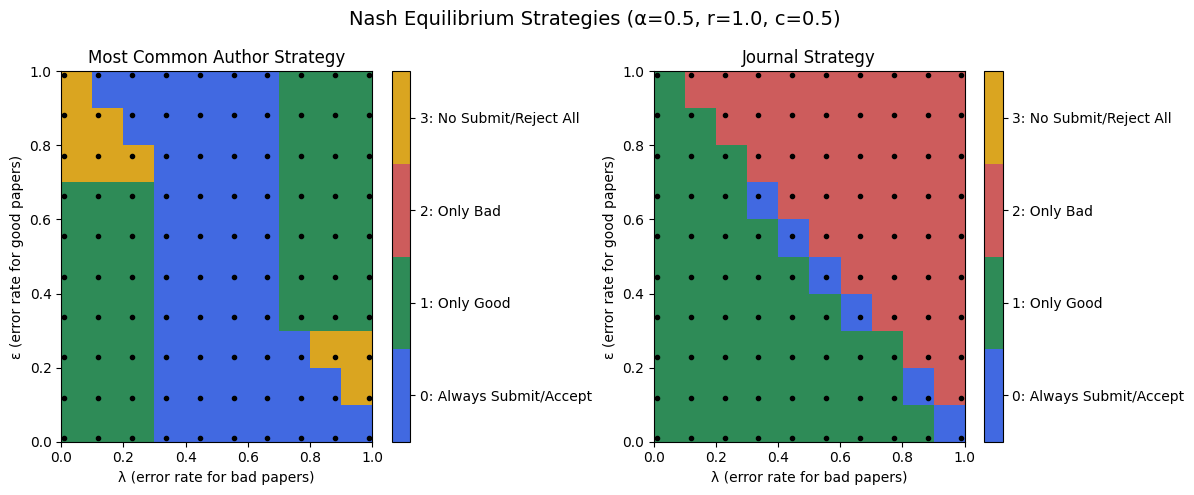



=============== SPECIFIC SCENARIOS ===============
Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 23042.66it/s]



Nash Equilibria for (α=0.5, ε=0.1, λ=0.1, r=1.0, c=0.01):

Equilibrium #1:
  Authors: (0, 0, 0) (['Always Submit/Accept', 'Always Submit/Accept', 'Always Submit/Accept'])
  Journal: 1 (Only Submit/Accept Good)
  Author Payoffs: [0.495, 0.495, 0.495]
  Journal Quality: 0.9

Equilibrium #2:
  Authors: (3, 3, 3) (['No Submit/Reject All', 'No Submit/Reject All', 'No Submit/Reject All'])
  Journal: 3 (No Submit/Reject All)
  Author Payoffs: [0.0, 0.0, 0.0]
  Journal Quality: 0.0
Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 29746.01it/s]



Nash Equilibria for (α=0.5, ε=0.5, λ=0.5, r=1.0, c=0.1):

Equilibrium #1:
  Authors: (0, 0, 0) (['Always Submit/Accept', 'Always Submit/Accept', 'Always Submit/Accept'])
  Journal: 0 (Always Submit/Accept)
  Author Payoffs: [1.0, 1.0, 1.0]
  Journal Quality: 0.5

Equilibrium #2:
  Authors: (0, 0, 0) (['Always Submit/Accept', 'Always Submit/Accept', 'Always Submit/Accept'])
  Journal: 1 (Only Submit/Accept Good)
  Author Payoffs: [0.45, 0.45, 0.45]
  Journal Quality: 0.5

Equilibrium #3:
  Authors: (0, 0, 0) (['Always Submit/Accept', 'Always Submit/Accept', 'Always Submit/Accept'])
  Journal: 2 (Only Submit/Accept Bad)
  Author Payoffs: [0.45, 0.45, 0.45]
  Journal Quality: 0.5

Equilibrium #4:
  Authors: (3, 3, 3) (['No Submit/Reject All', 'No Submit/Reject All', 'No Submit/Reject All'])
  Journal: 3 (No Submit/Reject All)
  Author Payoffs: [0.0, 0.0, 0.0]
  Journal Quality: 0.0
Checking 256 strategy profiles for Nash equilibria...


100%|██████████| 256/256 [00:00<00:00, 27796.98it/s]


Nash Equilibria for (α=0.5, ε=0.8, λ=0.8, r=1.0, c=0.5):

Equilibrium #1:
  Authors: (1, 1, 1) (['Only Submit/Accept Good', 'Only Submit/Accept Good', 'Only Submit/Accept Good'])
  Journal: 2 (Only Submit/Accept Bad)
  Author Payoffs: [0.35, 0.35, 0.35]
  Journal Quality: 1.0

Equilibrium #2:
  Authors: (2, 2, 2) (['Only Submit/Accept Bad', 'Only Submit/Accept Bad', 'Only Submit/Accept Bad'])
  Journal: 1 (Only Submit/Accept Good)
  Author Payoffs: [0.35, 0.35, 0.35]
  Journal Quality: 0.0

Equilibrium #3:
  Authors: (3, 3, 3) (['No Submit/Reject All', 'No Submit/Reject All', 'No Submit/Reject All'])
  Journal: 3 (No Submit/Reject All)
  Author Payoffs: [0.0, 0.0, 0.0]
  Journal Quality: 0.0


In [17]:
if __name__ == "__main__":
    main()